In [7]:
import numpy as np
from glob import glob
import os
from PIL import Image
import cv2
from tqdm import tqdm

images = glob("fingertip/train/images/*.jpg")

sliced_images = list()

for image in tqdm(images, total=len(images)):
  fname = os.path.basename(image)
  label = "fingertip/train/labels/"+fname[:-4]+".txt"
  image = np.array(Image.open(image))
  width, height, _ = image.shape

  mask = np.zeros((width, height), dtype=np.uint8)

  segmentations = list()
  bboxes = list()
  with open(label) as f:
    for line in f:
      coords = line.split(" ")
      x_coords = [int(float(coord) * width) for i, coord in enumerate(coords) if i % 2 != 0]
      y_coords = [int(float(coord) * height) for i, coord in enumerate(coords) if i % 2 == 0]
      del y_coords[0]

      segmentation = list(zip(x_coords, y_coords))
      segmentations.append(np.array(segmentation))
      bbox = [min(x_coords), min(y_coords), max(x_coords), max(y_coords)]
      bboxes.append(bbox)

      sliced_images.append(cv2.cvtColor(image[bbox[1]:bbox[3], bbox[0]:bbox[2], :],cv2.COLOR_BGR2RGB))

  mask = cv2.fillPoly(mask, segmentations, 1)

  masked_img1 = mask * image[:, :, 0]
  masked_img2 = mask * image[:, :, 1]
  masked_img3 = mask * image[:, :, 2]
  masked_img = cv2.merge((masked_img1, masked_img2, masked_img3))

100%|██████████| 414/414 [00:00<00:00, 479.86it/s]


In [8]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [9]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

class MyDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        if self.transform is not None:
            image = self.transform(image)

        return image, 0

batch_size = 128

train_dataset = MyDataset(sliced_images[:int(len(sliced_images) * 0.8)], transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MyDataset(sliced_images[int(len(sliced_images) * 0.8):], transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size // 8, shuffle=False)

# FC AutoEncoder

In [10]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # 3 * 64 * 64 -> 128 -> 64 -> 32 -> 16 -> 8 -> 4 -> 2 -> 1  ( 3 layers )
            nn.Linear(3 * 128 * 128, latent_dim*4), nn.ReLU(),
            nn.Linear(latent_dim*4, latent_dim*2), nn.ReLU(),
            nn.Linear(latent_dim*2, latent_dim), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, latent_dim*2), nn.ReLU(),
            nn.Linear(latent_dim*2, latent_dim*4), nn.ReLU(),
            nn.Linear(latent_dim*4, 3 * 128 * 128), nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(x.shape[0], 3, 128, 128)
        return x

In [11]:
import torch

epochs = 100

ae = Autoencoder(latent_dim=128)
optimizer = torch.optim.Adam(ae.parameters(), lr=3e-2)
criterion = nn.MSELoss()

for epoch in range(epochs):
  print(f"epoch : {epoch+1}")
  for data in tqdm(train_dataloader, total=len(train_dataloader)):
    images, _ = data
    images = images
    reconstructed = ae(images)

    loss = criterion(reconstructed, images)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print("train loss : ", loss.item())

  for data in tqdm(test_dataloader, total=len(test_dataloader)):
    images, _ = data
    images = images
    reconstructed = ae(images)

    loss = criterion(reconstructed, images)

  print("test loss : ", loss.item())

epoch : 1


100%|██████████| 11/11 [00:01<00:00,  8.14it/s]


train loss :  0.21202242374420166


100%|██████████| 21/21 [00:00<00:00, 87.24it/s]


test loss :  0.1825142204761505
epoch : 2


100%|██████████| 11/11 [00:01<00:00,  9.07it/s]


train loss :  0.22979722917079926


100%|██████████| 21/21 [00:00<00:00, 84.27it/s]


test loss :  0.1852695792913437
epoch : 3


100%|██████████| 11/11 [00:01<00:00,  8.95it/s]


train loss :  0.20678608119487762


100%|██████████| 21/21 [00:00<00:00, 87.57it/s]


test loss :  0.18181003630161285
epoch : 4


100%|██████████| 11/11 [00:01<00:00,  8.93it/s]


train loss :  0.22457733750343323


100%|██████████| 21/21 [00:00<00:00, 86.76it/s]


test loss :  0.18102945387363434
epoch : 5


100%|██████████| 11/11 [00:01<00:00,  9.11it/s]


train loss :  0.23954834043979645


100%|██████████| 21/21 [00:00<00:00, 84.79it/s]


test loss :  0.18085114657878876
epoch : 6


100%|██████████| 11/11 [00:01<00:00,  8.94it/s]


train loss :  0.23447708785533905


100%|██████████| 21/21 [00:00<00:00, 85.37it/s]


test loss :  0.18080554902553558
epoch : 7


100%|██████████| 11/11 [00:01<00:00,  8.80it/s]


train loss :  0.2320636808872223


100%|██████████| 21/21 [00:00<00:00, 87.93it/s]


test loss :  0.18076744675636292
epoch : 8


100%|██████████| 11/11 [00:01<00:00,  9.01it/s]


train loss :  0.23719367384910583


100%|██████████| 21/21 [00:00<00:00, 85.55it/s]


test loss :  0.1807529330253601
epoch : 9


100%|██████████| 11/11 [00:01<00:00,  9.08it/s]


train loss :  0.2474139779806137


100%|██████████| 21/21 [00:00<00:00, 89.21it/s]


test loss :  0.18075688183307648
epoch : 10


100%|██████████| 11/11 [00:01<00:00,  9.14it/s]


train loss :  0.2395087480545044


100%|██████████| 21/21 [00:00<00:00, 89.04it/s]


test loss :  0.18075688183307648
epoch : 11


100%|██████████| 11/11 [00:01<00:00,  9.08it/s]


train loss :  0.21460683643817902


100%|██████████| 21/21 [00:00<00:00, 84.69it/s]


test loss :  0.18075688183307648
epoch : 12


100%|██████████| 11/11 [00:01<00:00,  9.04it/s]


train loss :  0.22776615619659424


100%|██████████| 21/21 [00:00<00:00, 87.04it/s]


test loss :  0.18075688183307648
epoch : 13


100%|██████████| 11/11 [00:01<00:00,  9.26it/s]


train loss :  0.21266473829746246


100%|██████████| 21/21 [00:00<00:00, 88.70it/s]


test loss :  0.18075688183307648
epoch : 14


100%|██████████| 11/11 [00:01<00:00,  8.95it/s]


train loss :  0.2196110337972641


100%|██████████| 21/21 [00:00<00:00, 83.86it/s]


test loss :  0.18075688183307648
epoch : 15


100%|██████████| 11/11 [00:01<00:00,  8.83it/s]


train loss :  0.22490385174751282


100%|██████████| 21/21 [00:00<00:00, 81.06it/s]


test loss :  0.18075688183307648
epoch : 16


100%|██████████| 11/11 [00:01<00:00,  9.00it/s]


train loss :  0.22605326771736145


100%|██████████| 21/21 [00:00<00:00, 78.11it/s]


test loss :  0.18075688183307648
epoch : 17


100%|██████████| 11/11 [00:01<00:00,  9.09it/s]


train loss :  0.22898651659488678


100%|██████████| 21/21 [00:00<00:00, 85.98it/s]


test loss :  0.18075688183307648
epoch : 18


100%|██████████| 11/11 [00:01<00:00,  9.26it/s]


train loss :  0.230788454413414


100%|██████████| 21/21 [00:00<00:00, 90.03it/s]


test loss :  0.18075688183307648
epoch : 19


100%|██████████| 11/11 [00:01<00:00,  9.01it/s]


train loss :  0.2275923490524292


100%|██████████| 21/21 [00:00<00:00, 87.48it/s]


test loss :  0.18075688183307648
epoch : 20


100%|██████████| 11/11 [00:01<00:00,  9.24it/s]


train loss :  0.25490617752075195


100%|██████████| 21/21 [00:00<00:00, 87.34it/s]


test loss :  0.18075688183307648
epoch : 21


100%|██████████| 11/11 [00:01<00:00,  9.22it/s]


train loss :  0.2567273676395416


100%|██████████| 21/21 [00:00<00:00, 91.56it/s]


test loss :  0.18075688183307648
epoch : 22


100%|██████████| 11/11 [00:01<00:00,  9.13it/s]


train loss :  0.24358797073364258


100%|██████████| 21/21 [00:00<00:00, 83.53it/s]


test loss :  0.18075688183307648
epoch : 23


100%|██████████| 11/11 [00:01<00:00,  8.78it/s]


train loss :  0.22516636550426483


100%|██████████| 21/21 [00:00<00:00, 89.35it/s]


test loss :  0.18075688183307648
epoch : 24


100%|██████████| 11/11 [00:01<00:00,  8.92it/s]


train loss :  0.23731482028961182


100%|██████████| 21/21 [00:00<00:00, 85.96it/s]


test loss :  0.18075688183307648
epoch : 25


100%|██████████| 11/11 [00:01<00:00,  8.80it/s]


train loss :  0.22441400587558746


100%|██████████| 21/21 [00:00<00:00, 86.96it/s]


test loss :  0.18075688183307648
epoch : 26


100%|██████████| 11/11 [00:01<00:00,  9.00it/s]


train loss :  0.23252837359905243


100%|██████████| 21/21 [00:00<00:00, 89.38it/s]


test loss :  0.18075688183307648
epoch : 27


100%|██████████| 11/11 [00:01<00:00,  9.38it/s]


train loss :  0.23636457324028015


100%|██████████| 21/21 [00:00<00:00, 86.12it/s]


test loss :  0.18075688183307648
epoch : 28


100%|██████████| 11/11 [00:01<00:00,  8.55it/s]


train loss :  0.21831516921520233


100%|██████████| 21/21 [00:00<00:00, 86.06it/s]


test loss :  0.18075688183307648
epoch : 29


100%|██████████| 11/11 [00:01<00:00,  8.96it/s]


train loss :  0.22432197630405426


100%|██████████| 21/21 [00:00<00:00, 87.70it/s]


test loss :  0.18075688183307648
epoch : 30


100%|██████████| 11/11 [00:01<00:00,  8.84it/s]


train loss :  0.2348872870206833


100%|██████████| 21/21 [00:00<00:00, 82.57it/s]


test loss :  0.18075688183307648
epoch : 31


100%|██████████| 11/11 [00:01<00:00,  8.82it/s]


train loss :  0.2380087971687317


100%|██████████| 21/21 [00:00<00:00, 88.07it/s]


test loss :  0.18075688183307648
epoch : 32


100%|██████████| 11/11 [00:01<00:00,  9.20it/s]


train loss :  0.21922080218791962


100%|██████████| 21/21 [00:00<00:00, 89.44it/s]


test loss :  0.18075688183307648
epoch : 33


100%|██████████| 11/11 [00:01<00:00,  8.93it/s]


train loss :  0.23541590571403503


100%|██████████| 21/21 [00:00<00:00, 86.25it/s]


test loss :  0.18075688183307648
epoch : 34


100%|██████████| 11/11 [00:01<00:00,  8.91it/s]


train loss :  0.2285890281200409


100%|██████████| 21/21 [00:00<00:00, 88.66it/s]


test loss :  0.18075688183307648
epoch : 35


100%|██████████| 11/11 [00:01<00:00,  9.05it/s]


train loss :  0.2210160195827484


100%|██████████| 21/21 [00:00<00:00, 83.43it/s]


test loss :  0.18075688183307648
epoch : 36


100%|██████████| 11/11 [00:01<00:00,  8.83it/s]


train loss :  0.2268272191286087


100%|██████████| 21/21 [00:00<00:00, 85.42it/s]


test loss :  0.18075688183307648
epoch : 37


100%|██████████| 11/11 [00:01<00:00,  9.12it/s]


train loss :  0.24310402572155


100%|██████████| 21/21 [00:00<00:00, 90.02it/s]


test loss :  0.18075688183307648
epoch : 38


100%|██████████| 11/11 [00:01<00:00,  8.87it/s]


train loss :  0.2243645042181015


100%|██████████| 21/21 [00:00<00:00, 79.95it/s]


test loss :  0.18075688183307648
epoch : 39


100%|██████████| 11/11 [00:01<00:00,  8.90it/s]


train loss :  0.23001675307750702


100%|██████████| 21/21 [00:00<00:00, 84.84it/s]


test loss :  0.18075688183307648
epoch : 40


100%|██████████| 11/11 [00:01<00:00,  9.06it/s]


train loss :  0.20614051818847656


100%|██████████| 21/21 [00:00<00:00, 90.98it/s]


test loss :  0.18075688183307648
epoch : 41


100%|██████████| 11/11 [00:01<00:00,  9.23it/s]


train loss :  0.22600047290325165


100%|██████████| 21/21 [00:00<00:00, 85.68it/s]


test loss :  0.18075688183307648
epoch : 42


100%|██████████| 11/11 [00:01<00:00,  9.12it/s]


train loss :  0.2213732898235321


100%|██████████| 21/21 [00:00<00:00, 88.38it/s]


test loss :  0.18075688183307648
epoch : 43


100%|██████████| 11/11 [00:01<00:00,  9.24it/s]


train loss :  0.22172962129116058


100%|██████████| 21/21 [00:00<00:00, 92.06it/s]


test loss :  0.18075688183307648
epoch : 44


100%|██████████| 11/11 [00:01<00:00,  9.29it/s]


train loss :  0.238846093416214


100%|██████████| 21/21 [00:00<00:00, 87.80it/s]


test loss :  0.18075688183307648
epoch : 45


100%|██████████| 11/11 [00:01<00:00,  9.12it/s]


train loss :  0.23508422076702118


100%|██████████| 21/21 [00:00<00:00, 84.95it/s]


test loss :  0.18075688183307648
epoch : 46


100%|██████████| 11/11 [00:01<00:00,  9.01it/s]


train loss :  0.2204182893037796


100%|██████████| 21/21 [00:00<00:00, 90.06it/s]


test loss :  0.18075688183307648
epoch : 47


100%|██████████| 11/11 [00:01<00:00,  9.25it/s]


train loss :  0.24408800899982452


100%|██████████| 21/21 [00:00<00:00, 89.00it/s]


test loss :  0.18075688183307648
epoch : 48


100%|██████████| 11/11 [00:01<00:00,  8.95it/s]


train loss :  0.2250528335571289


100%|██████████| 21/21 [00:00<00:00, 85.44it/s]


test loss :  0.18075688183307648
epoch : 49


100%|██████████| 11/11 [00:01<00:00,  8.78it/s]


train loss :  0.2266617715358734


100%|██████████| 21/21 [00:00<00:00, 89.43it/s]


test loss :  0.18075688183307648
epoch : 50


100%|██████████| 11/11 [00:01<00:00,  9.19it/s]


train loss :  0.22341930866241455


100%|██████████| 21/21 [00:00<00:00, 90.54it/s]


test loss :  0.18075688183307648
epoch : 51


100%|██████████| 11/11 [00:01<00:00,  9.10it/s]


train loss :  0.24774610996246338


100%|██████████| 21/21 [00:00<00:00, 87.00it/s]


test loss :  0.18075688183307648
epoch : 52


100%|██████████| 11/11 [00:01<00:00,  8.95it/s]


train loss :  0.23067942261695862


100%|██████████| 21/21 [00:00<00:00, 89.18it/s]


test loss :  0.18075688183307648
epoch : 53


100%|██████████| 11/11 [00:01<00:00,  9.29it/s]


train loss :  0.21984049677848816


100%|██████████| 21/21 [00:00<00:00, 86.52it/s]


test loss :  0.18075688183307648
epoch : 54


100%|██████████| 11/11 [00:01<00:00,  8.99it/s]


train loss :  0.231452077627182


100%|██████████| 21/21 [00:00<00:00, 87.95it/s]


test loss :  0.18075688183307648
epoch : 55


100%|██████████| 11/11 [00:01<00:00,  9.06it/s]


train loss :  0.23391853272914886


100%|██████████| 21/21 [00:00<00:00, 87.01it/s]


test loss :  0.18075688183307648
epoch : 56


100%|██████████| 11/11 [00:01<00:00,  9.22it/s]


train loss :  0.22955521941184998


100%|██████████| 21/21 [00:00<00:00, 90.32it/s]


test loss :  0.18075688183307648
epoch : 57


100%|██████████| 11/11 [00:01<00:00,  9.23it/s]


train loss :  0.24446704983711243


100%|██████████| 21/21 [00:00<00:00, 87.24it/s]


test loss :  0.18075688183307648
epoch : 58


100%|██████████| 11/11 [00:01<00:00,  9.00it/s]


train loss :  0.22054152190685272


100%|██████████| 21/21 [00:00<00:00, 86.65it/s]


test loss :  0.18075688183307648
epoch : 59


100%|██████████| 11/11 [00:01<00:00,  9.19it/s]


train loss :  0.219199538230896


100%|██████████| 21/21 [00:00<00:00, 90.29it/s]


test loss :  0.18075688183307648
epoch : 60


100%|██████████| 11/11 [00:01<00:00,  9.27it/s]


train loss :  0.21982058882713318


100%|██████████| 21/21 [00:00<00:00, 86.93it/s]


test loss :  0.18075688183307648
epoch : 61


100%|██████████| 11/11 [00:01<00:00,  9.08it/s]


train loss :  0.21913832426071167


100%|██████████| 21/21 [00:00<00:00, 88.00it/s]


test loss :  0.18075688183307648
epoch : 62


100%|██████████| 11/11 [00:01<00:00,  9.17it/s]


train loss :  0.23649810254573822


100%|██████████| 21/21 [00:00<00:00, 91.62it/s]


test loss :  0.18075688183307648
epoch : 63


100%|██████████| 11/11 [00:01<00:00,  9.22it/s]


train loss :  0.22685740888118744


100%|██████████| 21/21 [00:00<00:00, 90.41it/s]


test loss :  0.18075688183307648
epoch : 64


100%|██████████| 11/11 [00:01<00:00,  9.00it/s]


train loss :  0.21265679597854614


100%|██████████| 21/21 [00:00<00:00, 87.39it/s]


test loss :  0.18075688183307648
epoch : 65


100%|██████████| 11/11 [00:01<00:00,  9.07it/s]


train loss :  0.23483411967754364


100%|██████████| 21/21 [00:00<00:00, 91.06it/s]


test loss :  0.18075688183307648
epoch : 66


100%|██████████| 11/11 [00:01<00:00,  9.25it/s]


train loss :  0.2145404815673828


100%|██████████| 21/21 [00:00<00:00, 91.35it/s]


test loss :  0.18075688183307648
epoch : 67


100%|██████████| 11/11 [00:01<00:00,  9.09it/s]


train loss :  0.23063351213932037


100%|██████████| 21/21 [00:00<00:00, 87.98it/s]


test loss :  0.18075688183307648
epoch : 68


100%|██████████| 11/11 [00:01<00:00,  9.07it/s]


train loss :  0.22217269241809845


100%|██████████| 21/21 [00:00<00:00, 90.80it/s]


test loss :  0.18075688183307648
epoch : 69


100%|██████████| 11/11 [00:01<00:00,  9.26it/s]


train loss :  0.24683436751365662


100%|██████████| 21/21 [00:00<00:00, 90.44it/s]


test loss :  0.18075688183307648
epoch : 70


100%|██████████| 11/11 [00:01<00:00,  9.09it/s]


train loss :  0.2264862060546875


100%|██████████| 21/21 [00:00<00:00, 87.30it/s]


test loss :  0.18075688183307648
epoch : 71


100%|██████████| 11/11 [00:01<00:00,  9.04it/s]


train loss :  0.23477484285831451


100%|██████████| 21/21 [00:00<00:00, 87.78it/s]


test loss :  0.18075688183307648
epoch : 72


100%|██████████| 11/11 [00:01<00:00,  9.19it/s]


train loss :  0.22353821992874146


100%|██████████| 21/21 [00:00<00:00, 91.23it/s]


test loss :  0.18075688183307648
epoch : 73


100%|██████████| 11/11 [00:01<00:00,  9.17it/s]


train loss :  0.22228148579597473


100%|██████████| 21/21 [00:00<00:00, 86.47it/s]


test loss :  0.18075688183307648
epoch : 74


100%|██████████| 11/11 [00:01<00:00,  9.06it/s]


train loss :  0.23365943133831024


100%|██████████| 21/21 [00:00<00:00, 87.27it/s]


test loss :  0.18075688183307648
epoch : 75


100%|██████████| 11/11 [00:01<00:00,  9.24it/s]


train loss :  0.22563111782073975


100%|██████████| 21/21 [00:00<00:00, 89.61it/s]


test loss :  0.18075688183307648
epoch : 76


100%|██████████| 11/11 [00:01<00:00,  9.30it/s]


train loss :  0.23720212280750275


100%|██████████| 21/21 [00:00<00:00, 86.02it/s]


test loss :  0.18075688183307648
epoch : 77


100%|██████████| 11/11 [00:01<00:00,  9.06it/s]


train loss :  0.23350045084953308


100%|██████████| 21/21 [00:00<00:00, 87.73it/s]


test loss :  0.18075688183307648
epoch : 78


100%|██████████| 11/11 [00:01<00:00,  9.21it/s]


train loss :  0.25294801592826843


100%|██████████| 21/21 [00:00<00:00, 91.22it/s]


test loss :  0.18075688183307648
epoch : 79


100%|██████████| 11/11 [00:01<00:00,  9.26it/s]


train loss :  0.22548216581344604


100%|██████████| 21/21 [00:00<00:00, 90.89it/s]


test loss :  0.18075688183307648
epoch : 80


100%|██████████| 11/11 [00:01<00:00,  8.97it/s]


train loss :  0.22166113555431366


100%|██████████| 21/21 [00:00<00:00, 87.31it/s]


test loss :  0.18075688183307648
epoch : 81


100%|██████████| 11/11 [00:01<00:00,  9.09it/s]


train loss :  0.22413241863250732


100%|██████████| 21/21 [00:00<00:00, 91.25it/s]


test loss :  0.18075688183307648
epoch : 82


100%|██████████| 11/11 [00:01<00:00,  9.11it/s]


train loss :  0.2360030561685562


100%|██████████| 21/21 [00:00<00:00, 88.11it/s]


test loss :  0.18075688183307648
epoch : 83


100%|██████████| 11/11 [00:01<00:00,  8.92it/s]


train loss :  0.2369767427444458


100%|██████████| 21/21 [00:00<00:00, 86.43it/s]


test loss :  0.18075688183307648
epoch : 84


100%|██████████| 11/11 [00:01<00:00,  9.03it/s]


train loss :  0.23130424320697784


100%|██████████| 21/21 [00:00<00:00, 90.54it/s]


test loss :  0.18075688183307648
epoch : 85


100%|██████████| 11/11 [00:01<00:00,  9.21it/s]


train loss :  0.23156321048736572


100%|██████████| 21/21 [00:00<00:00, 90.22it/s]


test loss :  0.18075688183307648
epoch : 86


100%|██████████| 11/11 [00:01<00:00,  9.10it/s]


train loss :  0.23267564177513123


100%|██████████| 21/21 [00:00<00:00, 87.39it/s]


test loss :  0.18075688183307648
epoch : 87


100%|██████████| 11/11 [00:01<00:00,  9.11it/s]


train loss :  0.2153342366218567


100%|██████████| 21/21 [00:00<00:00, 88.12it/s]


test loss :  0.18075688183307648
epoch : 88


100%|██████████| 11/11 [00:01<00:00,  9.29it/s]


train loss :  0.2187623530626297


100%|██████████| 21/21 [00:00<00:00, 89.47it/s]


test loss :  0.18075688183307648
epoch : 89


100%|██████████| 11/11 [00:01<00:00,  9.17it/s]


train loss :  0.24338892102241516


100%|██████████| 21/21 [00:00<00:00, 87.28it/s]


test loss :  0.18075688183307648
epoch : 90


100%|██████████| 11/11 [00:01<00:00,  9.04it/s]


train loss :  0.22869440913200378


100%|██████████| 21/21 [00:00<00:00, 88.24it/s]


test loss :  0.18075688183307648
epoch : 91


100%|██████████| 11/11 [00:01<00:00,  9.14it/s]


train loss :  0.22525379061698914


100%|██████████| 21/21 [00:00<00:00, 89.52it/s]


test loss :  0.18075688183307648
epoch : 92


100%|██████████| 11/11 [00:01<00:00,  9.21it/s]


train loss :  0.24245262145996094


100%|██████████| 21/21 [00:00<00:00, 85.63it/s]


test loss :  0.18075688183307648
epoch : 93


100%|██████████| 11/11 [00:01<00:00,  9.09it/s]


train loss :  0.2599095106124878


100%|██████████| 21/21 [00:00<00:00, 88.46it/s]


test loss :  0.18075688183307648
epoch : 94


100%|██████████| 11/11 [00:01<00:00,  9.23it/s]


train loss :  0.2221662700176239


100%|██████████| 21/21 [00:00<00:00, 89.91it/s]


test loss :  0.18075688183307648
epoch : 95


100%|██████████| 11/11 [00:01<00:00,  9.24it/s]


train loss :  0.22113007307052612


100%|██████████| 21/21 [00:00<00:00, 89.92it/s]


test loss :  0.18075688183307648
epoch : 96


100%|██████████| 11/11 [00:01<00:00,  9.12it/s]


train loss :  0.24479259550571442


100%|██████████| 21/21 [00:00<00:00, 87.90it/s]


test loss :  0.18075688183307648
epoch : 97


100%|██████████| 11/11 [00:01<00:00,  9.10it/s]


train loss :  0.23968537151813507


100%|██████████| 21/21 [00:00<00:00, 90.03it/s]


test loss :  0.18075688183307648
epoch : 98


100%|██████████| 11/11 [00:01<00:00,  9.25it/s]


train loss :  0.2208133041858673


100%|██████████| 21/21 [00:00<00:00, 90.08it/s]


test loss :  0.18075688183307648
epoch : 99


100%|██████████| 11/11 [00:01<00:00,  9.10it/s]


train loss :  0.23850588500499725


100%|██████████| 21/21 [00:00<00:00, 87.02it/s]


test loss :  0.18075688183307648
epoch : 100


100%|██████████| 11/11 [00:01<00:00,  9.12it/s]


train loss :  0.24309179186820984


100%|██████████| 21/21 [00:00<00:00, 90.58it/s]

test loss :  0.18075688183307648


In [78]:
import time
sample = test_transform(Image.fromarray(sliced_images[5])).reshape(1, 3, 128, 128)
ae.eval()
start = time.time()
ae_sample = ae(sample)
print(time.time()-start)

0.003049135208129883


In [79]:
sampleimg = sample.reshape(3, 128, 128).permute(1, 2, 0).detach().numpy()
ae_sample = sample.reshape(3, 128, 128).permute(1, 2, 0).detach().numpy()

In [80]:
sampleimg = cv2.cvtColor(sampleimg, cv2.COLOR_BGR2RGB)
ae_sample = cv2.cvtColor(ae_sample, cv2.COLOR_BGR2RGB)

In [81]:
sampleimg *= 255.0
sampleimg = sampleimg.astype(np.uint8)

ae_sample *= 255.0
ae_sample = ae_sample.astype(np.uint8)

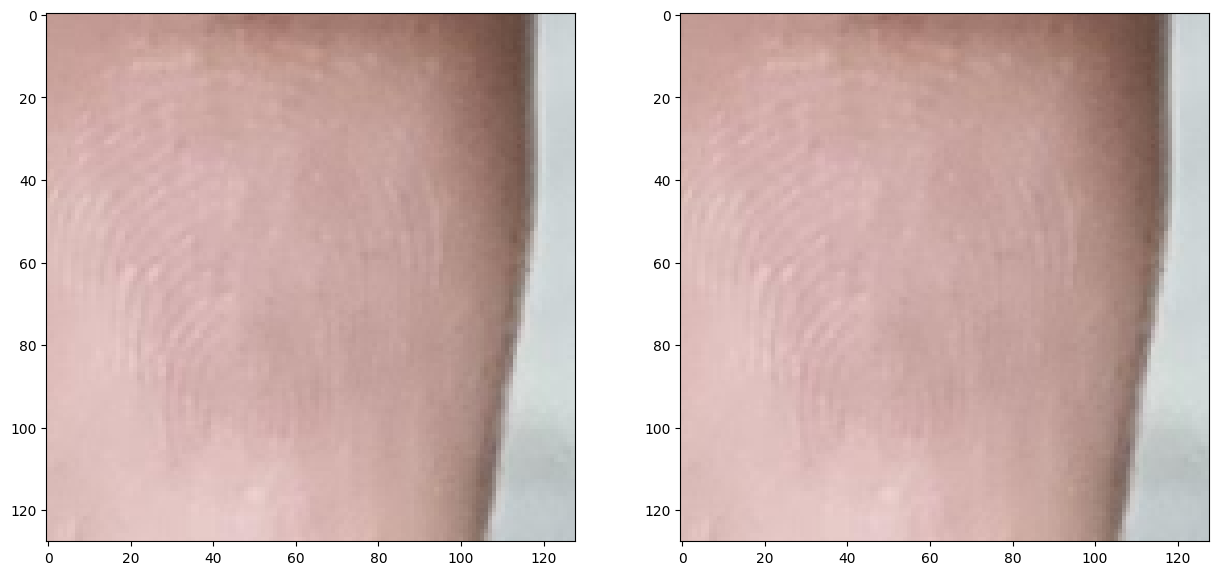

In [84]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 2)
f.set_figheight(15)
f.set_figwidth(15)
ax[0].imshow(np.array(Image.fromarray(sampleimg)))
ax[1].imshow(np.array(Image.fromarray(ae_sample)))
plt.show()

# Conv AutoEncoder

In [121]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.linear = nn.Linear(128 * 16 * 16, latent_dim)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv3(x))
        x = x.view(-1, 128 * 16 * 16)
        x = self.linear(x)
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.linear = nn.Linear(latent_dim, 128 * 16 * 16)
        self.conv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.conv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.conv3 = nn.ConvTranspose2d(32, 3, kernel_size=3, padding=1)

    def forward(self, z):
        x = self.linear(z).view(-1, 128, 16, 16)
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.interpolate(x, scale_factor=2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.interpolate(x, scale_factor=2)
        x = nn.functional.sigmoid(self.conv3(x))
        return x

class ConvAutoencoder(nn.Module):
  def __init__(self, latent_dim):
    super(ConvAutoencoder, self).__init__()
    self.encoder = Encoder(latent_dim)
    self.decoder = Decoder(latent_dim)

  def forward(self, x):
    z = self.encoder(x)
    reconstructed = self.decoder(z)
    return reconstructed

In [123]:
import torch

epochs = 20

cae = ConvAutoencoder(latent_dim=128).to('cuda')
optimizer = torch.optim.Adam(cae.parameters(), lr=3e-2)
criterion = nn.MSELoss()

for epoch in range(epochs):
  print(f"epoch : {epoch+1}")
  for data in tqdm(train_dataloader, total=len(train_dataloader)):
    images, _ = data
    images = images.to('cuda')
    reconstructed = cae(images)

    loss = criterion(reconstructed, images)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print("train loss : ", loss.item())

  for data in tqdm(test_dataloader, total=len(test_dataloader)):
    images, _ = data
    images = images.to('cuda')
    reconstructed = cae(images)

    loss = criterion(reconstructed, images)

  print("test loss : ", loss.item())

epoch : 1


100%|██████████| 211/211 [00:06<00:00, 34.32it/s]


train loss :  0.17722299695014954


100%|██████████| 422/422 [00:01<00:00, 283.64it/s]


test loss :  0.09324374049901962
epoch : 2


100%|██████████| 211/211 [00:07<00:00, 29.07it/s]


train loss :  0.18967315554618835


100%|██████████| 422/422 [00:01<00:00, 282.41it/s]


test loss :  0.09324374049901962
epoch : 3


100%|██████████| 211/211 [00:05<00:00, 36.25it/s]


train loss :  0.1780514121055603


100%|██████████| 422/422 [00:01<00:00, 296.44it/s]


test loss :  0.09324374049901962
epoch : 4


100%|██████████| 211/211 [00:08<00:00, 24.18it/s]


train loss :  0.15747375786304474


100%|██████████| 422/422 [00:01<00:00, 291.38it/s]


test loss :  0.09324374049901962
epoch : 5


100%|██████████| 211/211 [00:05<00:00, 36.78it/s]


train loss :  0.18727508187294006


100%|██████████| 422/422 [00:02<00:00, 202.49it/s]


test loss :  0.09324374049901962
epoch : 6


100%|██████████| 211/211 [00:07<00:00, 27.00it/s]


train loss :  0.18985724449157715


100%|██████████| 422/422 [00:01<00:00, 235.21it/s]


test loss :  0.09324374049901962
epoch : 7


100%|██████████| 211/211 [00:08<00:00, 25.41it/s]


train loss :  0.17946721613407135


100%|██████████| 422/422 [00:01<00:00, 235.94it/s]


test loss :  0.09324374049901962
epoch : 8


100%|██████████| 211/211 [00:06<00:00, 34.51it/s]


train loss :  0.2286067008972168


100%|██████████| 422/422 [00:01<00:00, 270.95it/s]


test loss :  0.09324374049901962
epoch : 9


100%|██████████| 211/211 [00:07<00:00, 29.60it/s]


train loss :  0.15977875888347626


100%|██████████| 422/422 [00:01<00:00, 293.06it/s]


test loss :  0.09324374049901962
epoch : 10


100%|██████████| 211/211 [00:06<00:00, 34.32it/s]


train loss :  0.18534593284130096


100%|██████████| 422/422 [00:01<00:00, 253.77it/s]


test loss :  0.09324374049901962
epoch : 11


100%|██████████| 211/211 [00:06<00:00, 31.14it/s]


train loss :  0.15099355578422546


100%|██████████| 422/422 [00:01<00:00, 283.90it/s]


test loss :  0.09324374049901962
epoch : 12


100%|██████████| 211/211 [00:05<00:00, 36.24it/s]


train loss :  0.17673206329345703


100%|██████████| 422/422 [00:02<00:00, 204.22it/s]


test loss :  0.09324374049901962
epoch : 13


100%|██████████| 211/211 [00:08<00:00, 24.60it/s]


train loss :  0.1863999366760254


100%|██████████| 422/422 [00:03<00:00, 131.96it/s]


test loss :  0.09324374049901962
epoch : 14


100%|██████████| 211/211 [00:08<00:00, 26.06it/s]


train loss :  0.1594381034374237


100%|██████████| 422/422 [00:01<00:00, 280.11it/s]


test loss :  0.09324374049901962
epoch : 15


100%|██████████| 211/211 [00:05<00:00, 35.82it/s]


train loss :  0.21989017724990845


100%|██████████| 422/422 [00:01<00:00, 243.90it/s]


test loss :  0.09324374049901962
epoch : 16


100%|██████████| 211/211 [00:06<00:00, 30.25it/s]


train loss :  0.1831618994474411


100%|██████████| 422/422 [00:01<00:00, 284.22it/s]


test loss :  0.09324374049901962
epoch : 17


100%|██████████| 211/211 [00:05<00:00, 36.94it/s]


train loss :  0.1488266885280609


100%|██████████| 422/422 [00:01<00:00, 211.14it/s]


test loss :  0.09324374049901962
epoch : 18


100%|██████████| 211/211 [00:06<00:00, 31.62it/s]


train loss :  0.18589679896831512


100%|██████████| 422/422 [00:01<00:00, 282.16it/s]


test loss :  0.09324374049901962
epoch : 19


100%|██████████| 211/211 [00:08<00:00, 25.81it/s]


train loss :  0.17626748979091644


100%|██████████| 422/422 [00:02<00:00, 209.09it/s]


test loss :  0.09324374049901962
epoch : 20


100%|██████████| 211/211 [00:05<00:00, 36.39it/s]


train loss :  0.1874171644449234


100%|██████████| 422/422 [00:01<00:00, 290.42it/s]

test loss :  0.09324374049901962


In [142]:
import time
sample = test_transform(Image.fromarray(sliced_images[1])).reshape(1, 3, 64, 64).to('cuda')
cae.eval()
start = time.time()
cae(sample)
print(time.time()-start)

0.015395879745483398
